In [1]:
import os
import sys

sys.path.append("./")  # Adds higher directory to python modules path.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from data_pipeline import *
import numpy as np
import pandas as pd
from core.ODEDataset import  ODEDataset
from utils import cleaning, constants

In [2]:
print("Available devices:", tf.config.list_physical_devices())
logical_devices = tf.config.list_logical_devices()
print("Active logical devices:", logical_devices)

print("Version : ", tf.__version__)

Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Active logical devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Version :  2.11.0


Let's load the dataset and  select the columns we want to use as features and labels.

## Constants & Parameters

In [3]:
BATCH_SIZE = 256
Features = ['Years_of_HHH_in_community',
 'Dwelling_quality_index',
 'Hours_available_electricity',
 'Measurement_age',
 'Monthly_expenditure',
 'Number_of_rooms',
 'Climate_zone_lev_1',
 'Climate_zone_lev_2',
 'Age_HHH',
 'Number_adults',
 'HH_with_home_business_No',
 'HH_with_home_business_Yes',
 'Education_level_HHH_No schooling',
 'Education_level_HHH_Not classified',
 'Education_level_HHH_Primary',
 'Education_level_HHH_Secondary',
 'Education_level_HHH_Tertiary',
 'Socio_status_HHH_Employer',
 'Socio_status_HHH_Other',
 'Socio_status_HHH_Unemployed',
 'Socio_status_HHH_Worker',
 'Ownership_motorized_vehicle_No',
 'Ownership_motorized_vehicle_Yes',
 'Ownership_small_livestock_No',
 'Ownership_small_livestock_Yes',
 'Ownership_large_livestock_No',
 'Ownership_large_livestock_Yes',
 'Clean_fuel_No',
 'Clean_fuel_Yes',
 'Tariff_payment_frequency_Monthly or More',
 'Tariff_payment_frequency_Weekly or More',
 'Tariff_payment_frequency_other']
FEATURE_NUM = len(Features)



In [4]:
# OUTPUT =  "Presence_refrigerator/freezer"
# OUTPUT =  "Presence_iron" 
OUTPUT =  "Presence_fan" 
# OUTPUT =  "Presence_DVD_player" 
# OUTPUT =  "Presence_radio/stereo"
# OUTPUT =  "Presence_phone_charger" 
# OUTPUT =  "Presence_TV" 

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
sampler = RandomOverSampler()

## Dataset and Feature Selection

In [6]:
train_dataset = ODEDataset("train_ds")
train_dataset.from_csv("./playground/data/normalized_train_set.csv", )
train_dataset = train_dataset.apply(cleaning.remove_row(OUTPUT, -1))

val_dataset = ODEDataset("val_ds")
val_dataset.from_csv("./playground/data/normalized_val_set.csv", )
val_dataset = val_dataset.apply(cleaning.remove_row(OUTPUT, -1))

test_dataset = ODEDataset("test_ds")
test_dataset.from_csv("./playground/data/normalized_test_set.csv", )
test_dataset = test_dataset.apply(cleaning.remove_row(OUTPUT, -1))


In [7]:
x_train, y_train = train_dataset.to_numpy(Features, OUTPUT)
x_val, y_val = val_dataset.to_numpy(Features, OUTPUT)
x_test, y_test = test_dataset.to_numpy(Features, OUTPUT)

In [8]:
# print("Trainging")
# for output in constants.PRESENCE_LIST: 
#     x_train, y_train = train_dataset.to_numpy(Features, output)
#     counter = Counter(y_train)
#     print(f"{output}: {counter[1]/(counter[0] + counter[1]): 0.2f}")
    
# print("Validation")
# for output in constants.PRESENCE_LIST: 
#     x_val, y_val = val_dataset.to_numpy(Features, output)
#     counter = Counter(y_val)
#     print(f"{output}: {counter[1]/(counter[0] + counter[1]): 0.2f}")
    
# print("Testing")
# for output in constants.PRESENCE_LIST: 
#     counter = Counter(y_test)
#     x_test, y_test = test_dataset.to_numpy(Features, output)
#     print(f"{output}: {counter[1]/(counter[0] + counter[1]): 0.2f}")

### Imbalanced Dataset Handling
We use Imbalanced learning library 
https://imbalanced-learn.org/stable/index.html

In [9]:
x_train, y_train = sampler.fit_resample(x_train, y_train )
x_val, y_val = sampler.fit_resample(x_val, y_val )
print(x_train.shape, y_train.shape)

(9022, 32) (9022,)


<BarContainer object of 2 artists>

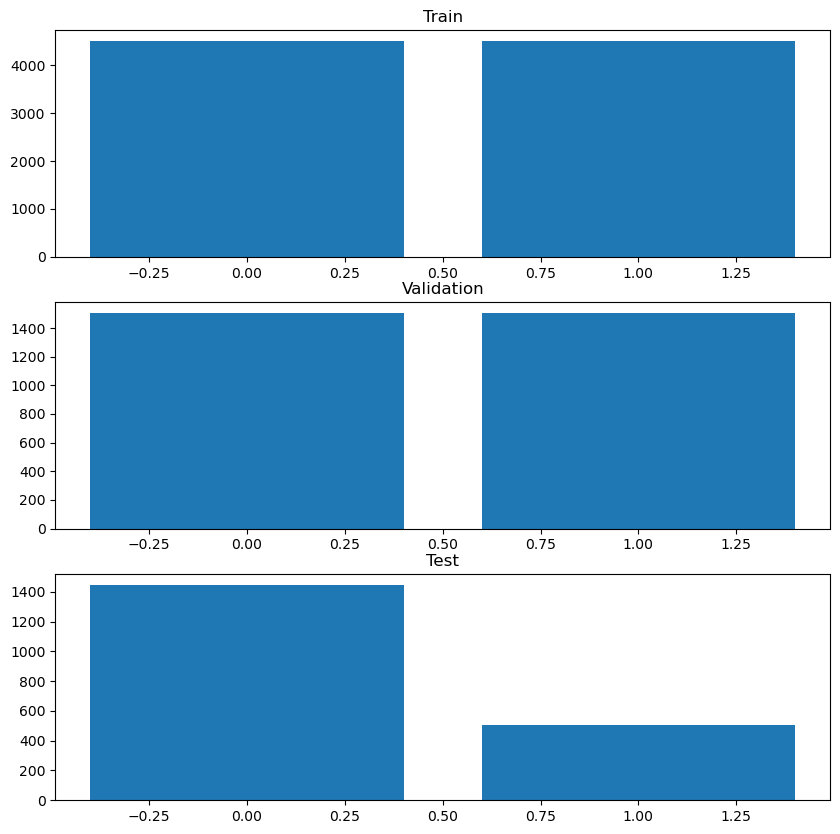

In [10]:
from collections import Counter
plt.figure(figsize=(10, 10))
cnt = Counter(y_train)
plt.subplot(3, 1, 1)
plt.title("Train")
plt.bar(cnt.keys(), cnt.values())

plt.subplot(3, 1, 2)
cnt = Counter(y_val)
plt.title("Validation")
plt.bar(cnt.keys(), cnt.values())


plt.subplot(3, 1, 3)
cnt = Counter(y_test)
plt.title("Test")
plt.bar(cnt.keys(), cnt.values())





In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))

train_ds = train_ds.shuffle(10010).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val.astype(np.float32), y_val.astype(np.float32)))

val_ds = val_ds.shuffle(10010).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test.astype(np.float32), y_test.astype(np.float32)))



## Model

In [12]:
def residual_block(input_tensor, units, activation=tf.keras.layers.ReLU(),dropout=0.1, bn=True, regularizer=None):
    # First layer in the block
    x = tf.keras.layers.Dense(units, kernel_regularizer=regularizer)(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    
    # Second layer in the block
    x = tf.keras.layers.Dense(units, kernel_regularizer=regularizer)(x)
    if bn:
        
        x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Dropout(dropout)(x)
    # Skip connection (adding input to output)
    x = tf.keras.layers.Add()([x, input_tensor])
    x = activation(x)  # Activation after addition
    return x

def layer_block(x, units, activation=tf.keras.layers.ReLU(),dropout=0.1, bn=True, regularizer=None):
    x = tf.keras.layers.Dense(units, kernel_regularizer=regularizer)(x)
    
    if bn:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Dropout(dropout)(x)
    x = activation(x)
    return x


In [13]:
THRESHOLD = 0.5
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
LOSS = tf.keras.losses.BinaryCrossentropy()
EPOCHS = 10000

In [14]:
initializer = tf.keras.initializers.GlorotNormal(21)  
regularizer = tf.keras.regularizers.l2(0.01)

units = 128
n_blocks = 8
dropout = 0.4
activation = tf.keras.layers.ReLU()

bn = True
# Input layer

input_tensor = tf.keras.layers.Input(shape=(FEATURE_NUM,))


x = layer_block(input_tensor, units, activation=activation,dropout=dropout, bn=bn, regularizer=regularizer)

for i in range(n_blocks-1):    
    x = layer_block(x, units, activation=activation,dropout=dropout, bn=bn, regularizer=regularizer)

# Output layer  
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)


model = tf.keras.Model(inputs=input_tensor, outputs=output)

model.compile(optimizer=OPTIMIZER, loss=LOSS, 
              metrics=[
                        tf.keras.metrics.AUC(name='auc'),
                        ])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          4224        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128)         512         ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['batch_normalization[0][0]']

In [15]:
class_weight = {0: 1, 1: 2.0}  # Higher weight for the minority class (1)
PATIENCE = 100
monitor = 'val_auc'
EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(
    monitor=monitor,  # Metric to monitor
    patience=PATIENCE,            # Number of epochs to wait for improvement
    restore_best_weights=True,  # Restore weights from the best epoch
    mode='max',

)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=monitor,  # Metric to monitor
    factor=0.99,          # Reduce learning rate by this factor (90%)
    patience=PATIENCE + 20,          # Wait for 3 epochs of no improvement
    min_delta=1e-2,
    
)

CALLBACKS = [
    EARLY_STOPPING, 
    reduce_lr
]

history = model.fit(train_ds, epochs=EPOCHS,
                    validation_data=val_ds, 
                    class_weight=class_weight,
                    callbacks=CALLBACKS
                    )


Epoch 1/10000


36/36 [==============================] - 7s 20ms/step - loss: 9.7039 - auc: 0.5147 - val_loss: 8.3872 - val_auc: 0.7363 - lr: 0.0010
Epoch 2/10000
36/36 [==============================] - 0s 10ms/step - loss: 7.9826 - auc: 0.5837 - val_loss: 6.9435 - val_auc: 0.8278 - lr: 0.0010
Epoch 3/10000
36/36 [==============================] - 0s 11ms/step - loss: 6.4122 - auc: 0.7990 - val_loss: 5.6876 - val_auc: 0.9240 - lr: 0.0010
Epoch 4/10000
36/36 [==============================] - 0s 10ms/step - loss: 5.0593 - auc: 0.9155 - val_loss: 4.5898 - val_auc: 0.9454 - lr: 0.0010
Epoch 5/10000
36/36 [==============================] - 0s 11ms/step - loss: 4.0388 - auc: 0.9389 - val_loss: 3.6829 - val_auc: 0.9496 - lr: 0.0010
Epoch 6/10000
36/36 [==============================] - 0s 11ms/step - loss: 3.2160 - auc: 0.9472 - val_loss: 2.9628 - val_auc: 0.9518 - lr: 0.0010
Epoch 7/10000
36/36 [==============================] - 0s 11ms/step - loss: 2.5674 - auc: 0.9520 - val_loss: 2.4361 - val_auc: 0.955

## Visualization & Evaluation

In [16]:
def draw_metric(history, metric):
        
    train_metric = history.history[metric]
    val_metric = history.history[f'val_{metric}']

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_metric, label=f'Training {metric}', color='blue', )
    plt.plot(val_metric, label=f'Validation {metric}', color='orange',)
    plt.title(f'Training and Validation {metric.upper()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.upper())
    plt.legend()
    plt.grid(True)
    plt.show()
    

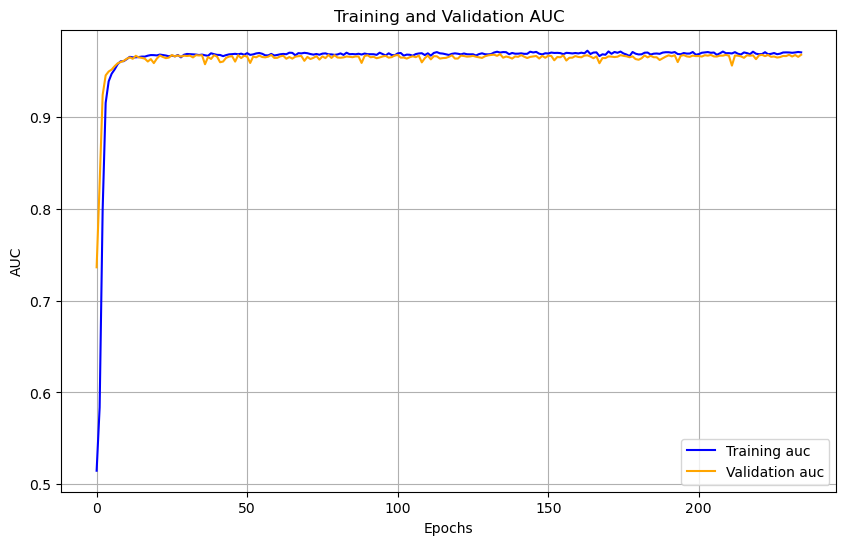

In [17]:
draw_metric(history, 'auc')

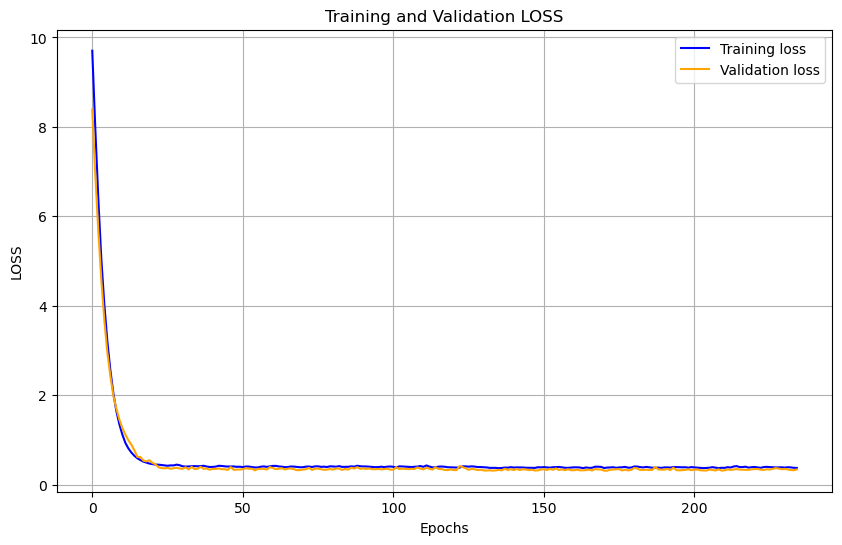

In [18]:
draw_metric(history, 'loss')

In [19]:
from sklearn.metrics import classification_report,accuracy_score,precision_score, recall_score, fbeta_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve

def get_classification_report(x, y_true, threshold=0.5):
 
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return classification_report(y_true, y_pred)

def get_fbeta_score(x, y_true, beta = 2, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return fbeta_score(y_true, y_pred, beta=beta, average='macro')

def get_precision(x, y_true, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return precision_score(y_true, y_pred, average='macro')

def get_accuracy(x, y_true, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return accuracy_score(y_true, y_pred)

def get_recall(x, y_true, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  # Convert probabilities to binary predictions

    return recall_score(y_true, y_pred, average='macro')

def get_auc(x, y_true):
    y_pred = model.predict(x, verbose=0)
    return roc_auc_score(y_true, y_pred)

def get_confusion_matrix(x, y_true, threshold=0.5):
    y_pred = model.predict(x, verbose=0)
    y_pred = ((y_pred >= threshold).astype(int).flatten())  
    cm = confusion_matrix(y_pred, y_true)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

def get_precision_recall_curve(x, y_true):
    y_pred = model.predict(x, verbose=0)
    # y_pred = ((y_pred >= threshold).astype(int).flatten())  
    ticks = np.linspace(0, 1, 50)
    plt.xticks(ticks)
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    # Find the index where precision and recall are closest
    
    plt.plot(thresholds, precision[:-1], label="Precision",)
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.title("Precision-Recall vs. Threshold")
    plt.show()
    



<Figure size 1200x600 with 0 Axes>

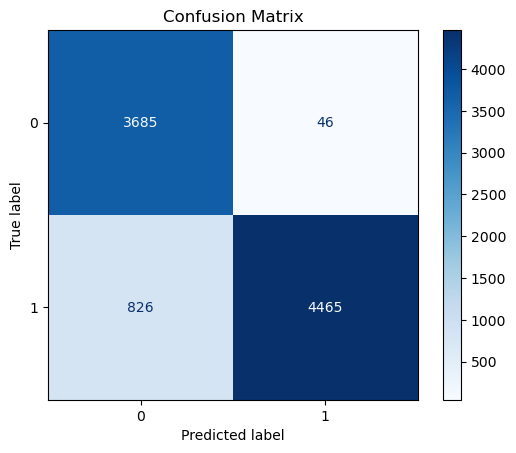

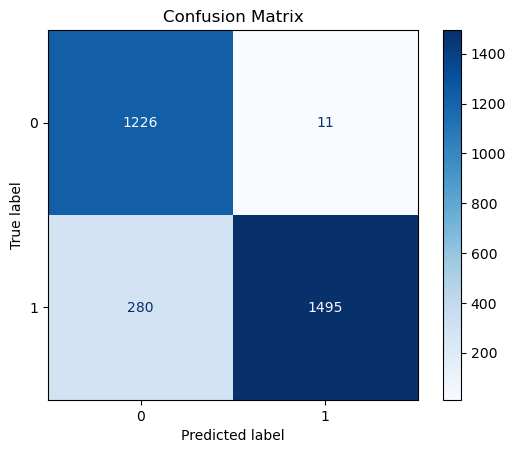

In [20]:

plt.figure(figsize=(12, 6))
x = x_train.astype(np.float32)
y = y_train.astype(np.float32)
get_confusion_matrix(x, y, THRESHOLD)

x = x_val.astype(np.float32)
y = y_val.astype(np.float32)
get_confusion_matrix(x, y, THRESHOLD)

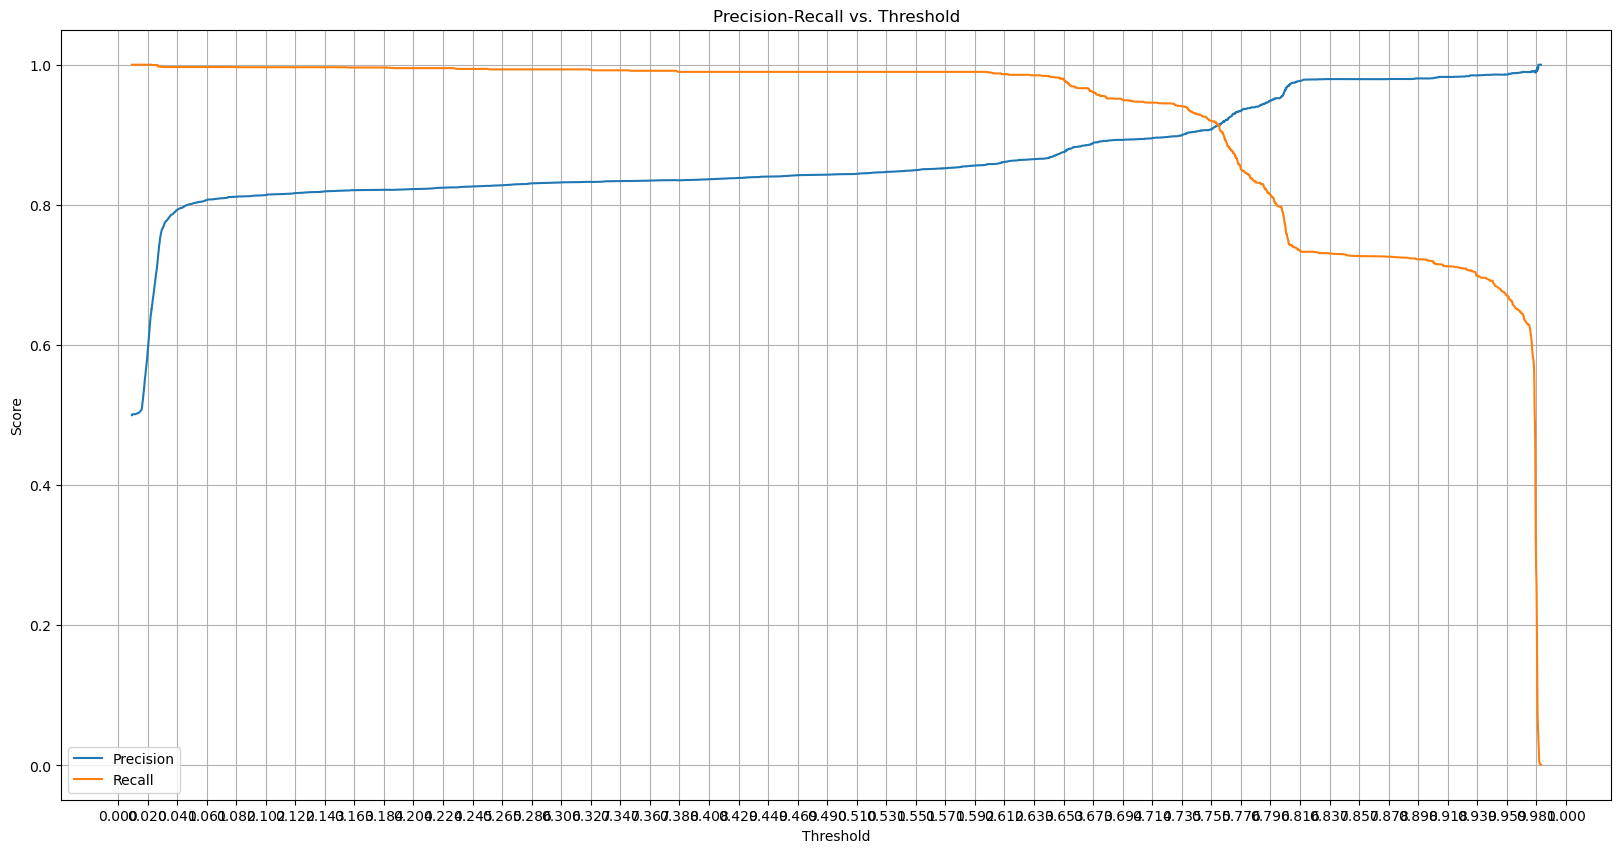

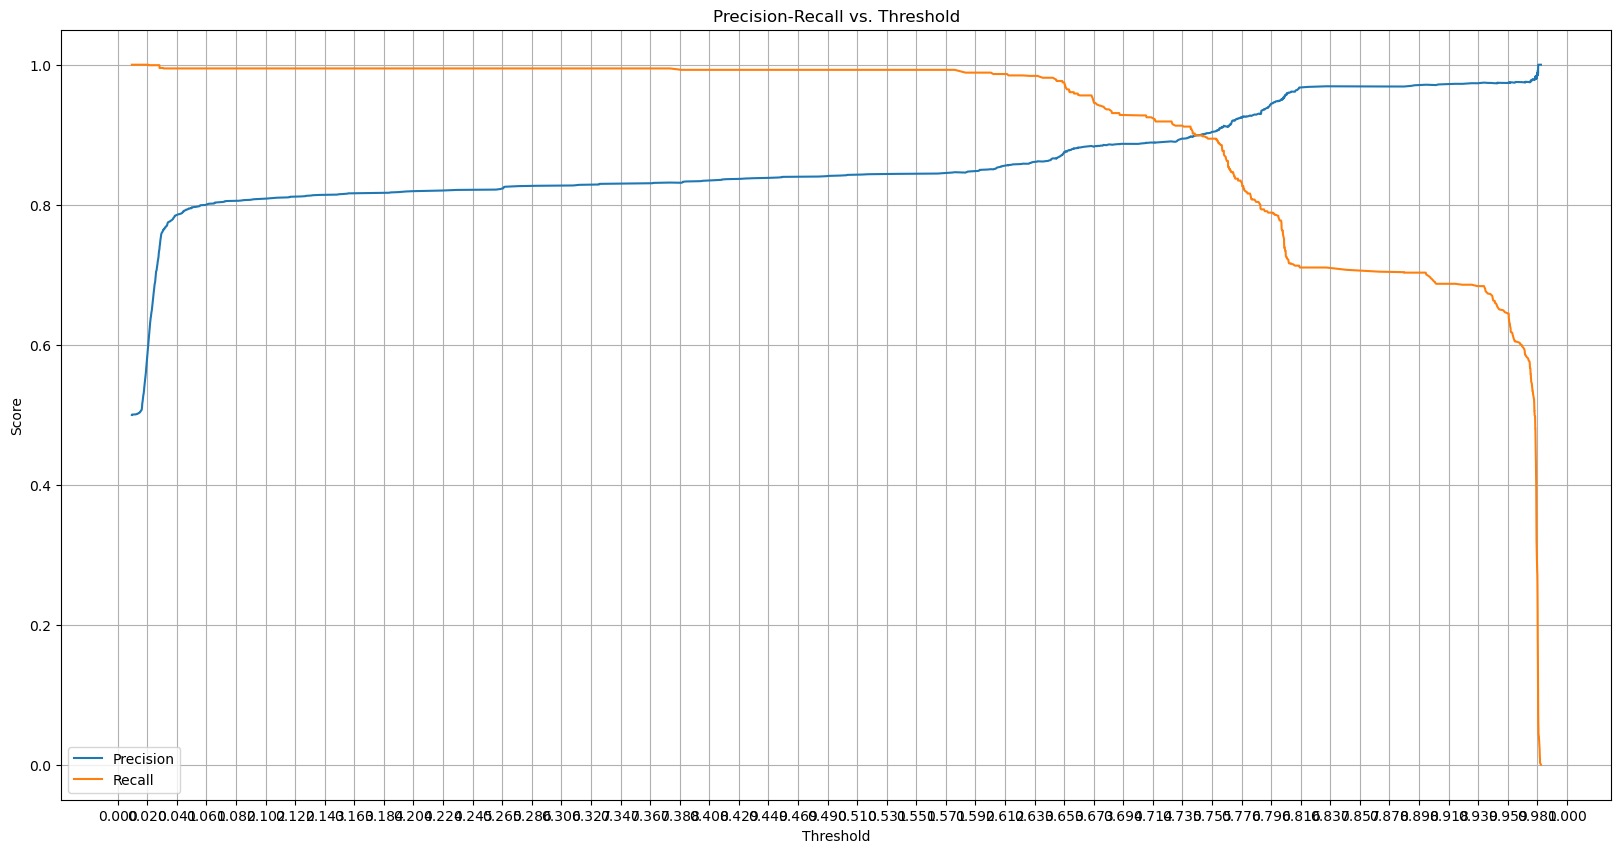

In [21]:

plt.figure(figsize=(20, 10))
plt.grid(True)
x = x_train.astype(np.float32)
y = y_train.astype(np.float32)
get_precision_recall_curve(x, y)
plt.figure(figsize=(20, 10))
x = x_val.astype(np.float32)
y = y_val.astype(np.float32)
plt.grid(True)
get_precision_recall_curve(x, y)


In [22]:
THRESHOLD = 0.5

In [23]:

print('| AUC  | Precision | Recall | F1 Score | F2 Score | Accuracy |')

x = x_train.astype(np.float32)
y = y_train.astype(np.float32)
f1 = get_fbeta_score(x, y, beta=1, threshold = THRESHOLD, )
pr = get_precision(x, y, THRESHOLD)
re = get_recall(x, y, THRESHOLD)
auc = get_auc(x, y)
f2 = get_fbeta_score(x, y, beta=2, threshold = THRESHOLD, )
acc = get_accuracy(x, y, THRESHOLD)
print("Training")
print(f'| {auc:.2f} | {pr:.2f} | {re:.2f} | {f1:.2f} | {f2:.2f} | {acc:.2f} |')

x = x_val.astype(np.float32)
y = y_val.astype(np.float32)
f1 = get_fbeta_score(x, y, beta=1, threshold = THRESHOLD, )
f2 = get_fbeta_score(x, y, beta=2, threshold = THRESHOLD, )
pr = get_precision(x, y, THRESHOLD)
re = get_recall(x, y, THRESHOLD)
auc = get_auc(x, y)
acc = get_accuracy(x, y, THRESHOLD)
print("Validation")

print(f'| {auc:.2f} | {pr:.2f} | {re:.2f} | {f1:.2f} | {f2:.2f} | {acc:.2f} |')


# x = x_test.astype(np.float32)
# y = y_test.astype(np.float32)
# f1 = get_fbeta_score(x, y, beta=1, threshold = THRESHOLD, )
# f2 = get_fbeta_score(x, y, beta=2, threshold = THRESHOLD, )
# pr = get_precision(x, y, THRESHOLD)
# re = get_recall(x, y, THRESHOLD)
# auc = get_auc(x, y)
# acc = get_accuracy(x, y, THRESHOLD)
# print("Testing")

# print(f'| {auc:.2f} | {pr:.2f} | {re:.2f} | {f1:.2f} | {f2:.2f} | {acc:.2f} |')






| AUC  | Precision | Recall | F1 Score | F2 Score | Accuracy |


Training
| 0.98 | 0.92 | 0.90 | 0.90 | 0.90 | 0.90 |
Validation
| 0.97 | 0.92 | 0.90 | 0.90 | 0.90 | 0.90 |


65/95 [===================>..........] - ETA: 0s

95/95 [==============================] - 0s 2ms/step


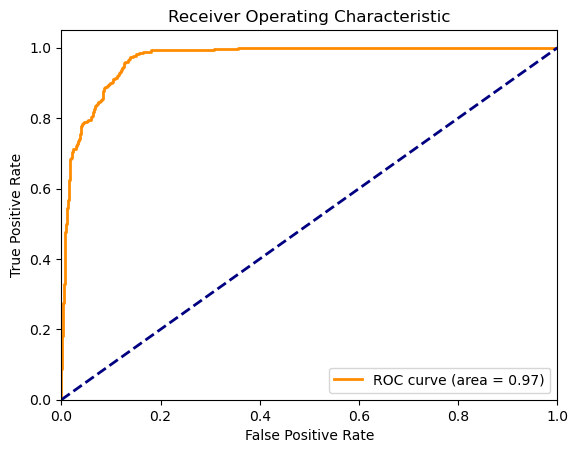

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have your model's predicted probabilities for the positive class
# Replace `model.predict_proba(x)[:, 1]` with your actual prediction method
y_pred_prob = model.predict(x)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [50]:
def draw_preds(_model, x, y, threshold=0.5):
    logits = _model.predict(x, verbose=0)
    logits = logits.flatten()
    points = []
    for i in range(len(logits)):
        log = logits[i]
        pred = 1 if log >= threshold else 0
        if pred != y[i]:
            if y[i] == 1:
                
                points.append({
                    "logit": log,
                    "i": i,
                    "color" : "red",
                    "label": "False Negative"
                })
            else: 
                points.append({
                    "logit": log,
                    "i": i,
                    "color" : "yellow",
                    "label": "False Positive"
                })
        else:
            if y[i] == 1:
                points.append({
                "logit": log,
                "i": i,
                "color" : "green",
                "label": "True Positive"
                })
            else:
                    
                points.append({
                    "logit": log,
                    "i": i,
                    "color" : "blue",
                    "label": "True Negative"
                })

    plt.figure(figsize=(10, 6))


    x = [point['i'] for point in points]
    y = [point['logit'] for point in points]
    colors = [point['color'] for point in points]
    labels = [point['label'] for point in points]

    plt.scatter(x, y, c=colors) 
    # Annotate the points
    plt.scatter([], [], c="green", label="True Positive")
    plt.scatter([], [], c="blue", label="True Negative")
    plt.scatter([], [], c="yellow", label="False Positive")
    plt.scatter([], [], c="red", label="False Negative")
    plt.legend()

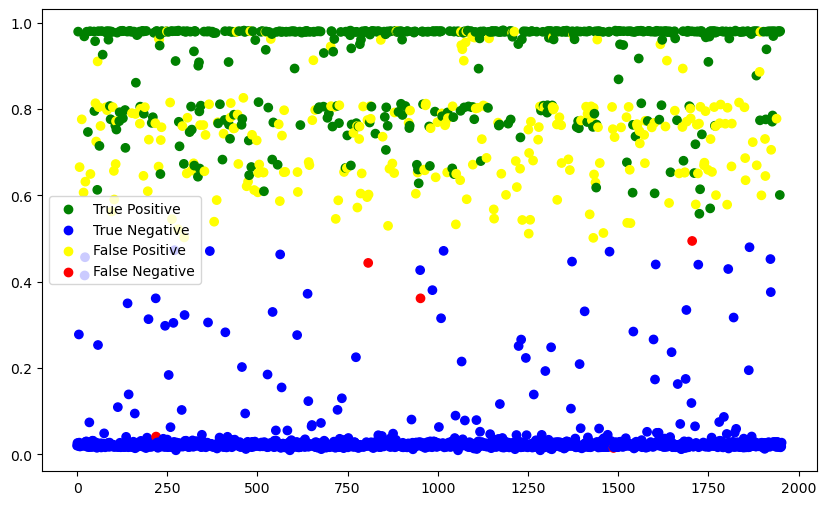

In [51]:
draw_preds(model, x_test, y_test, THRESHOLD)

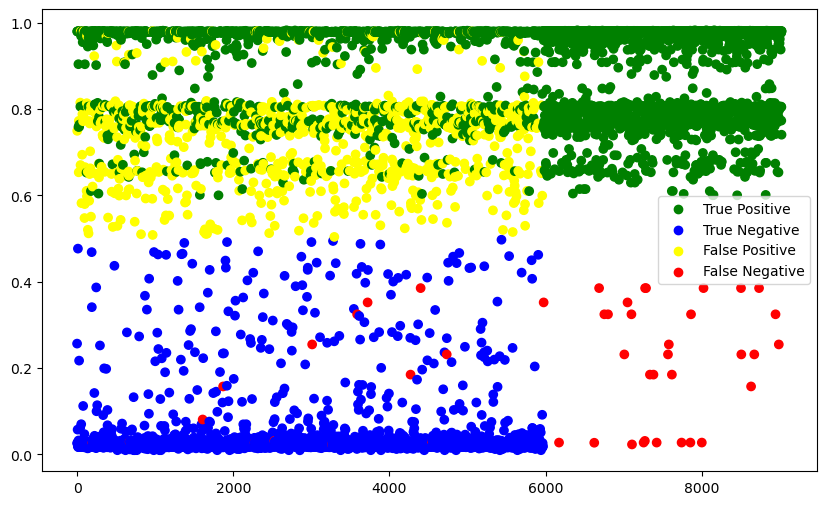

In [52]:
draw_preds(model, x_train, y_train, THRESHOLD)

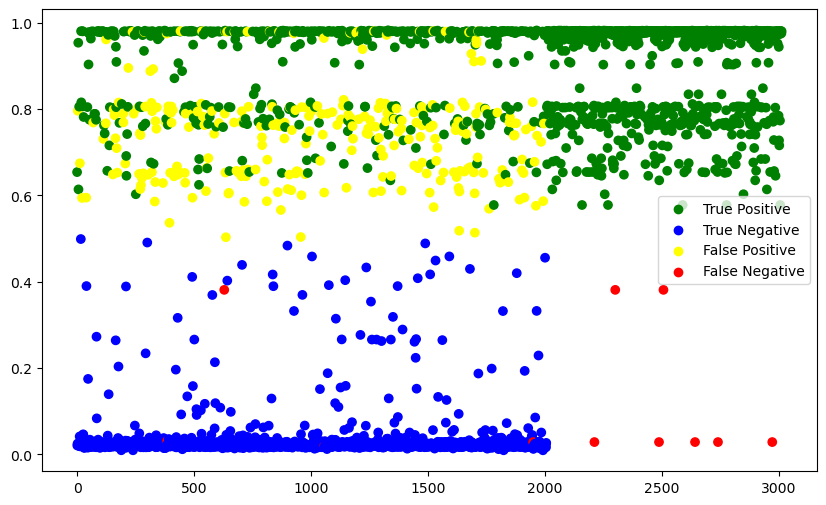

In [53]:
draw_preds(model, x_val, y_val, THRESHOLD)